In [2]:
import pandas as pd
mit_bih_df = pd.read_csv('/content/MIT-BIH Arrhythmia Database.csv')

In [4]:
from scipy.signal import butter, filtfilt
import numpy as np

# Step 1: Define a function to apply a low-pass filter to the ECG signals
def low_pass_filter(data, cutoff_frequency, fs, order=4):
    # Design the low-pass Butterworth filter
    nyquist = 0.5 * fs
    normal_cutoff = cutoff_frequency / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # Apply the filter to the data
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Step 2: Define a function to normalize the ECG signals (min-max normalization)
def normalize_signal(signal):
    normalized_signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    return normalized_signal

# Step 3: Segment the data into 10-second windows
def segment_data(data, window_size, fs):
    num_samples_per_window = window_size * fs
    segmented_data = [data[i:i + num_samples_per_window] for i in range(0, len(data), num_samples_per_window)]
    return segmented_data

# Parameters
fs = 360  # Assuming a sampling rate of 360 Hz for the ECG signal
cutoff_frequency = 50  # Low-pass filter cutoff frequency to remove high-frequency noise
window_size = 10  # Segmenting into 10-second windows

# Step 4: Apply the low-pass filter, normalization, and segmentation to Lead 0 and Lead 1 rPeak signals
mit_bih_df['0_rPeak_filtered'] = low_pass_filter(mit_bih_df['0_rPeak'], cutoff_frequency, fs)
mit_bih_df['1_rPeak_filtered'] = low_pass_filter(mit_bih_df['1_rPeak'], cutoff_frequency, fs)

# Normalize the filtered signals
mit_bih_df['0_rPeak_normalized'] = normalize_signal(mit_bih_df['0_rPeak_filtered'])
mit_bih_df['1_rPeak_normalized'] = normalize_signal(mit_bih_df['1_rPeak_filtered'])

# Segment the data into 10-second windows for further analysis
lead_0_segments = segment_data(mit_bih_df['0_rPeak_normalized'], window_size, fs)
lead_1_segments = segment_data(mit_bih_df['1_rPeak_normalized'], window_size, fs)

# Display a summary of the segmented data
len(lead_0_segments), len(lead_1_segments)  # Number of windows generated for each lead


(28, 28)

In [5]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 25.5 MB/s eta 0:00:00


In [19]:
import numpy as np
import pywt
from scipy.fft import fft

# Function to calculate R-R intervals
def calculate_rr_intervals(r_peak_signal):
    r_peak_indices = np.where(r_peak_signal > 0.3)[0]  # Threshold for R peaks
    rr_intervals = np.diff(r_peak_indices) / fs  # Convert to time (seconds)
    return rr_intervals

# Wavelet transform function
def wavelet_transform(signal, wavelet='db4', level=4):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    return coeffs

# Fourier transform function
def fourier_transform(signal):
    fft_result = fft(signal)
    return np.abs(fft_result)

# Extract features for each segment
def extract_features(segments):
    rr_features = []
    wavelet_features = []
    fft_features = []

    for segment in segments:
        rr_intervals = calculate_rr_intervals(segment)
        wavelet_coeffs = wavelet_transform(segment)
        fft_vals = fourier_transform(segment)

        rr_features.append(rr_intervals)
        wavelet_features.append(wavelet_coeffs)
        fft_features.append(fft_vals)

    return rr_features, wavelet_features, fft_features

# Convert segments to numpy arrays for proper signal processing
lead_0_segments_np = [np.array(segment) for segment in lead_0_segments]
lead_1_segments_np = [np.array(segment) for segment in lead_1_segments]

# Apply feature extraction
rr_intervals_lead_0, wavelet_lead_0, fft_lead_0 = extract_features(lead_0_segments_np)
rr_intervals_lead_1, wavelet_lead_1, fft_lead_1 = extract_features(lead_1_segments_np)

# Display sample extracted features
#print(rr_intervals_lead_0[:2], wavelet_lead_0[:2], fft_lead_0[:2])


In [20]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Feature extraction with fixed lengths for wavelet and FFT

# Function to flatten wavelet coefficients and ensure consistent length
def flatten_wavelet_coeffs(wavelet_coeffs, max_length=1000):
    flat_coeffs = np.hstack([coeff.flatten() for coeff in wavelet_coeffs])
    # Ensure the flattened wavelet coefficients have a fixed length
    if len(flat_coeffs) > max_length:
        return flat_coeffs[:max_length]
    else:
        return np.pad(flat_coeffs, (0, max_length - len(flat_coeffs)), 'constant')

# Combining extracted features into a single feature array
def combine_features(rr_intervals, wavelet_features, fft_features, wavelet_len=1000, fft_len=1000):
    features = []
    for rr, wavelet, fft in zip(rr_intervals, wavelet_features, fft_features):
        rr_mean = np.mean(rr) if len(rr) > 0 else 0
        rr_std = np.std(rr) if len(rr) > 0 else 0  # Adding standard deviation as an additional feature
        wavelet_flat = flatten_wavelet_coeffs(wavelet, wavelet_len)
        fft_flat = fft[:fft_len]  # Use first `fft_len` FFT coefficients as features
        combined_feature = np.hstack([rr_mean, rr_std, wavelet_flat, fft_flat])
        features.append(combined_feature)
    return np.array(features)

# Step 2: Combine features for the classifier using fixed lengths for wavelet and FFT
X = combine_features(rr_intervals_lead_0, wavelet_lead_0, fft_lead_0)

# Step 3: Load labels (assuming 'type' column in the original data has arrhythmia types)
y = mit_bih_df['type'].iloc[:len(X)]  # Assuming the labels are aligned with the feature array length

# Step 4: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 5: Train the Random Forest classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Step 6: Test the model
y_pred = clf.predict(X_test)

# Step 7: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Optional: Perform cross-validation to evaluate the model more robustly
cv_scores = cross_val_score(clf, X, y, cv=5)
print(f"Cross-validated Accuracy: {np.mean(cv_scores):.4f}")


Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Cross-validated Accuracy: 1.0000


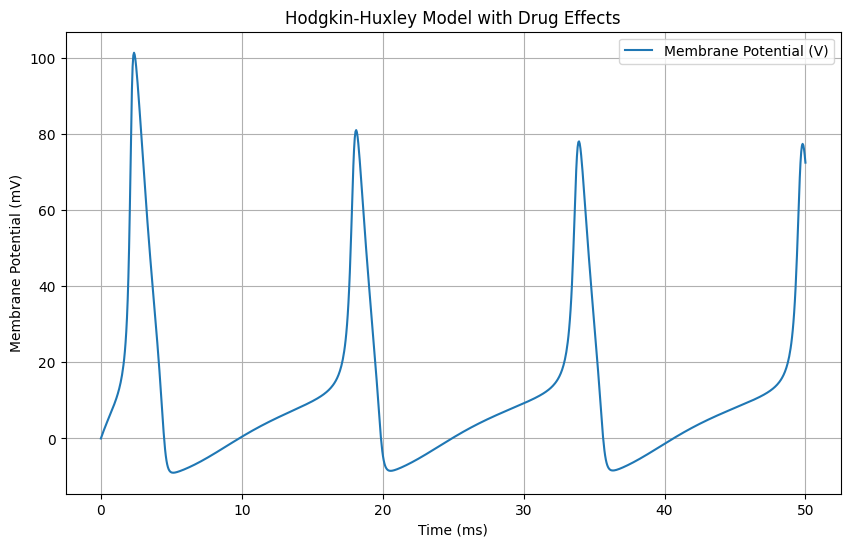

In [21]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Constants for the Hodgkin-Huxley model
C_m = 1.0    # Membrane capacitance (uF/cm^2)
E_Na = 115.0  # Sodium reversal potential (mV)
E_K = -12.0   # Potassium reversal potential (mV)
E_L = 10.613  # Leak reversal potential (mV)
g_Na = 120.0  # Sodium conductance (mS/cm^2)
g_K = 36.0    # Potassium conductance (mS/cm^2)
g_L = 0.3     # Leak conductance (mS/cm^2)

# External current (applied to the membrane)
I_ext = 10.0  # External current (uA/cm^2)

# Gating variables (m, h, n) ODEs
def alpha_m(V):
    return 0.1 * (25 - V) / (np.exp((25 - V) / 10) - 1)

def beta_m(V):
    return 4.0 * np.exp(-V / 18)

def alpha_h(V):
    return 0.07 * np.exp(-V / 20)

def beta_h(V):
    return 1 / (np.exp((30 - V) / 10) + 1)

def alpha_n(V):
    return 0.01 * (10 - V) / (np.exp((10 - V) / 10) - 1)

def beta_n(V):
    return 0.125 * np.exp(-V / 80)

# Hodgkin-Huxley equations
def hodgkin_huxley(y, t, drug_effects):
    V, m, h, n = y

    # Modify sodium and potassium conductance due to drug effects
    g_Na_mod = g_Na * drug_effects['Na_block']  # Drug effect on Na conductance
    g_K_mod = g_K * drug_effects['K_block']     # Drug effect on K conductance

    # Currents
    I_Na = g_Na_mod * (m ** 3) * h * (V - E_Na)
    I_K = g_K_mod * (n ** 4) * (V - E_K)
    I_L = g_L * (V - E_L)

    # Membrane potential derivative
    dVdt = (I_ext - I_Na - I_K - I_L) / C_m

    # Gating variables derivatives
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n

    return [dVdt, dmdt, dhdt, dndt]

# Initial conditions
V0 = 0.0    # Initial membrane potential
m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))  # Initial m gate
h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))  # Initial h gate
n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))  # Initial n gate
y0 = [V0, m0, h0, n0]

# Time array
t = np.linspace(0, 50, 1000)

# Define drug effects (Na_block and K_block can vary from 0 to 1, where 1 means no block)
drug_effects = {
    'Na_block': 0.6,  # 70% of normal sodium conductance (partial block)
    'K_block': 0.7,   # 50% of normal potassium conductance (stronger block)
}

# Solve the ODEs using odeint
solution = odeint(hodgkin_huxley, y0, t, args=(drug_effects,))

# Extract the membrane potential
V = solution[:, 0]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t, V, label="Membrane Potential (V)")
plt.title("Hodgkin-Huxley Model with Drug Effects")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.legend()
plt.grid()
plt.show()


<ipython-input-22-894d66196630>:80: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  solution = odeint(hodgkin_huxley_perturbed, y0, t, args=(drug_effects,), full_output=1)[0]


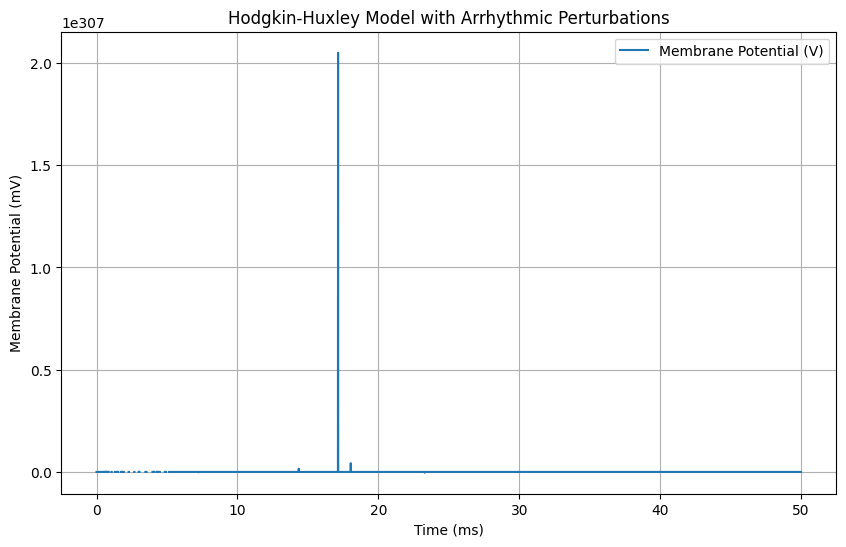

In [22]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Constants for the Hodgkin-Huxley model
C_m = 1.0    # Membrane capacitance (uF/cm^2)
E_Na = 115.0  # Sodium reversal potential (mV)
E_K = -12.0   # Potassium reversal potential (mV)
E_L = 10.613  # Leak reversal potential (mV)
g_Na = 120.0  # Sodium conductance (mS/cm^2)
g_K = 36.0    # Potassium conductance (mS/cm^2)
g_L = 0.3     # Leak conductance (mS/cm^2)

# External current (applied to the membrane)
I_ext_mean = 10.0  # Base external current (uA/cm^2)
I_ext_noise_strength = 5.0  # Strength of random noise added to external current

# Gating variables (m, h, n) ODEs
def alpha_m(V):
    return 0.1 * (25 - V) / (np.exp((25 - V) / 10) - 1)

def beta_m(V):
    return 4.0 * np.exp(-V / 18)

def alpha_h(V):
    return 0.07 * np.exp(-V / 20)

def beta_h(V):
    return 1 / (np.exp((30 - V) / 10) + 1)

def alpha_n(V):
    return 0.01 * (10 - V) / (np.exp((10 - V) / 10) - 1)

def beta_n(V):
    return 0.125 * np.exp(-V / 80)

# Hodgkin-Huxley equations with noise and perturbations
def hodgkin_huxley_perturbed(y, t, drug_effects):
    V, m, h, n = y

    # Modify sodium and potassium conductance due to drug effects or disease
    g_Na_mod = g_Na * drug_effects['Na_block']  # Drug effect on Na conductance
    g_K_mod = g_K * drug_effects['K_block']     # Drug effect on K conductance

    # Add random noise to the external current to simulate arrhythmic behavior
    I_ext = I_ext_mean + I_ext_noise_strength * np.random.randn()

    # Currents
    I_Na = g_Na_mod * (m ** 3) * h * (V - E_Na)
    I_K = g_K_mod * (n ** 4) * (V - E_K)
    I_L = g_L * (V - E_L)

    # Membrane potential derivative
    dVdt = (I_ext - I_Na - I_K - I_L) / C_m

    # Gating variables derivatives
    dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
    dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
    dndt = alpha_n(V) * (1 - n) - beta_n(V) * n

    return [dVdt, dmdt, dhdt, dndt]

# Initial conditions
V0 = 0.0    # Initial membrane potential
m0 = alpha_m(V0) / (alpha_m(V0) + beta_m(V0))  # Initial m gate
h0 = alpha_h(V0) / (alpha_h(V0) + beta_h(V0))  # Initial h gate
n0 = alpha_n(V0) / (alpha_n(V0) + beta_n(V0))  # Initial n gate
y0 = [V0, m0, h0, n0]

# Time array
t = np.linspace(0, 50, 5000)  # Increased resolution

# Define drug effects (Na_block and K_block can vary from 0 to 1, where 1 means no block)
drug_effects = {
    'Na_block': 0.7,  # 70% of normal sodium conductance (partial block)
    'K_block': 0.5,   # 50% of normal potassium conductance (stronger block)
}

# Solve the ODEs using odeint
solution = odeint(hodgkin_huxley_perturbed, y0, t, args=(drug_effects,), full_output=1)[0]

# Extract the membrane potential
V = solution[:, 0]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(t, V, label="Membrane Potential (V)")
plt.title("Hodgkin-Huxley Model with Arrhythmic Perturbations")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.legend()
plt.grid()
plt.show()


<ipython-input-23-094af618acee>:11: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  baseline_solution = odeint(hodgkin_huxley_perturbed, y0, t, args=(baseline_effects,), full_output=1)[0]


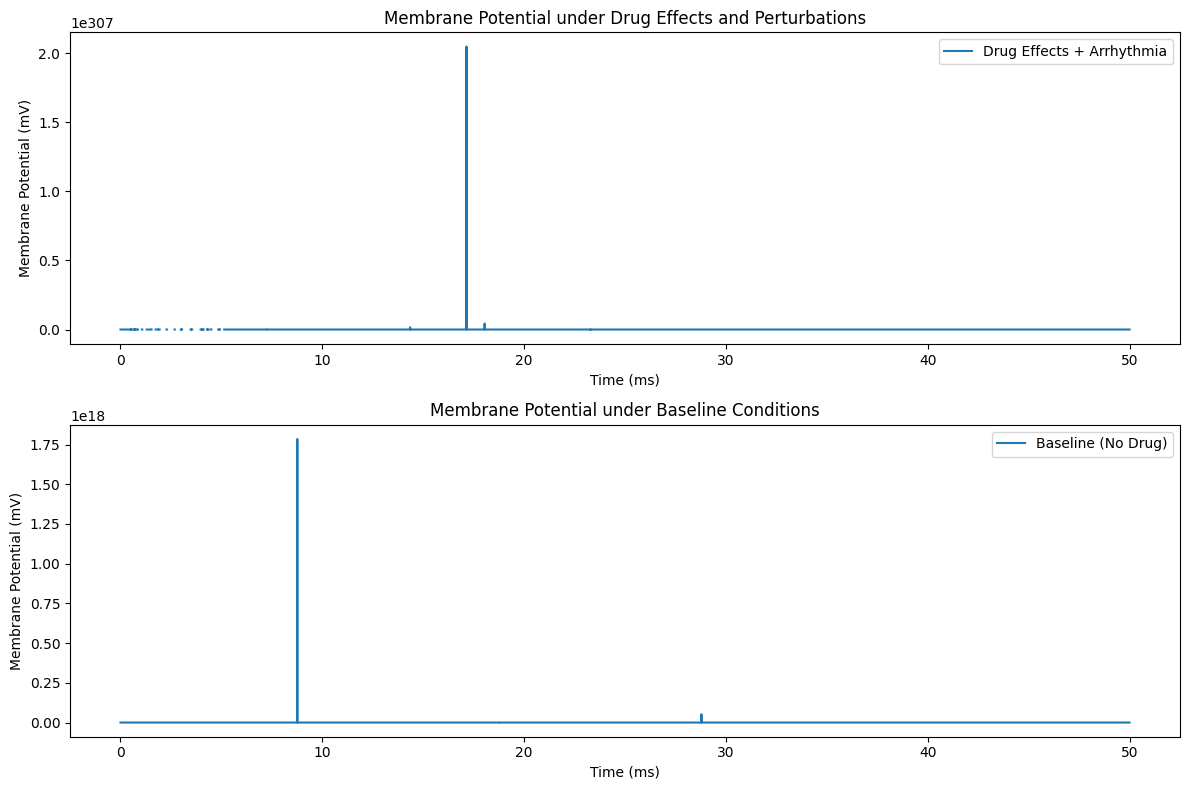

In [23]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(t, V, label="Drug Effects + Arrhythmia")
plt.title("Membrane Potential under Drug Effects and Perturbations")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.legend()

# Compare with baseline
baseline_effects = {'Na_block': 1.0, 'K_block': 1.0}  # No drug
baseline_solution = odeint(hodgkin_huxley_perturbed, y0, t, args=(baseline_effects,), full_output=1)[0]
plt.subplot(2, 1, 2)
plt.plot(t, baseline_solution[:, 0], label="Baseline (No Drug)")
plt.title("Membrane Potential under Baseline Conditions")
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.legend()
plt.tight_layout()
plt.show()


# Behavior Validation

In [24]:
def measure_firing_rate(V, threshold=-20):
    spikes = np.where((V[:-1] < threshold) & (V[1:] >= threshold))[0]
    firing_rate = len(spikes) / (t[-1] - t[0]) * 1000  # Spikes per second
    return firing_rate

def measure_apd(V, t, threshold=-50):
    above_threshold = V >= threshold
    crossing_points = np.diff(above_threshold.astype(int))
    apd_durations = t[np.where(crossing_points == -1)] - t[np.where(crossing_points == 1)]
    return np.mean(apd_durations) if len(apd_durations) > 0 else np.nan

baseline_apd = measure_apd(baseline_solution[:, 0], t)
drug_apd = measure_apd(V, t)
baseline_firing = measure_firing_rate(baseline_solution[:, 0])
drug_firing = measure_firing_rate(V)

print(f"Baseline APD: {baseline_apd} ms, Drug APD: {drug_apd} ms")
print(f"Baseline Firing Rate: {baseline_firing} Hz, Drug Firing Rate: {drug_firing} Hz")


Baseline APD: nan ms, Drug APD: -0.018610865030148957 ms
Baseline Firing Rate: 0.0 Hz, Drug Firing Rate: 3760.0 Hz


# Cross validation

In [25]:
def monte_carlo_simulation(num_simulations, t, y0):
    apd_results = []
    firing_results = []

    for i in range(num_simulations):
        # Randomize drug effects
        drug_effects = {
            'Na_block': np.random.uniform(0.5, 1.0),  # Sodium conductance block
            'K_block': np.random.uniform(0.3, 1.0),  # Potassium conductance block
        }

        # Run simulation
        solution = odeint(hodgkin_huxley_perturbed, y0, t, args=(drug_effects,))
        V = solution[:, 0]

        # Measure metrics
        apd = measure_apd(V, t)
        firing_rate = measure_firing_rate(V)
        apd_results.append(apd)
        firing_results.append(firing_rate)

        print(f"Simulation {i + 1}: Na_block = {drug_effects['Na_block']}, K_block = {drug_effects['K_block']}, APD = {apd}, Firing Rate = {firing_rate}")

    return apd_results, firing_results

# Run Monte Carlo
num_simulations = 50
apd_results, firing_results = monte_carlo_simulation(num_simulations, t, y0)

# Analyze results
print(f"Average APD: {np.mean(apd_results)}, Std Dev APD: {np.std(apd_results)}")
print(f"Average Firing Rate: {np.mean(firing_results)}, Std Dev Firing Rate: {np.std(firing_results)}")


<ipython-input-25-bd2361bad4b1>:13: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  solution = odeint(hodgkin_huxley_perturbed, y0, t, args=(drug_effects,))
<ipython-input-25-bd2361bad4b1>:13: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  solution = odeint(hodgkin_huxley_perturbed, y0, t, args=(drug_effects,))


Simulation 1: Na_block = 0.7271030203812769, K_block = 0.885255062907782, APD = nan, Firing Rate = 0.0
Simulation 2: Na_block = 0.9001145399104473, K_block = 0.4480465675390918, APD = nan, Firing Rate = 0.0
Simulation 3: Na_block = 0.5313115682648069, K_block = 0.7565108756642418, APD = nan, Firing Rate = 0.0
Simulation 4: Na_block = 0.9673180365185443, K_block = 0.9401916200102975, APD = nan, Firing Rate = 0.0
Simulation 5: Na_block = 0.7512885343156468, K_block = 0.522480115621965, APD = nan, Firing Rate = 0.0
Simulation 6: Na_block = 0.950502571902551, K_block = 0.3663608779687117, APD = nan, Firing Rate = 0.0
Simulation 7: Na_block = 0.8631509976631786, K_block = 0.9724962044944092, APD = nan, Firing Rate = 0.0
Simulation 8: Na_block = 0.6837696709347343, K_block = 0.44936149821302707, APD = nan, Firing Rate = 0.0
Simulation 9: Na_block = 0.7582150206092587, K_block = 0.3394527019449529, APD = nan, Firing Rate = 0.0
Simulation 10: Na_block = 0.6199714237651632, K_block = 0.92941695